# Final Project Report

* Class: DS 5100
* Student Name: Hana Nur
* Student Net ID: hrn4ch
* This URL: https://github.com/hrnur/hrn4ch_ds5100_montecarlo/blob/main/FinalProjectTemplate.ipynb

# Instructions

Follow the instructions in the [Final Project](https://ontoligent.github.io/DS5100-2023-07-R/notebooks/M00_FinalProject/FinalProjectInstructions.html) isntructions and put your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL: https://github.com/hrnur/hrn4ch_ds5100_montecarlo

Paste a copy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

```
import numpy as np
import pandas as pd

class Die:
    '''
    A die has sides and weights, and can be rolled to select a face. Each side contains a unique 
    symbol. Symbols may be all alphabetic or all numeric. The weights are just numbers, not a 
    normalized probability distribution. The die has one behavior, which is to be rolled one 
    or more times.
    '''
    def __init__(self, sides):
        '''
        Instantiates a Die object.
        
        INPUTS:
        sides - np.array of unique alphabetic or numeric sides
        '''
        if not isinstance(sides, np.ndarray):
            raise TypeError
        
        if not len(np.unique(sides))==len(sides):
            raise ValueError
        
        self.sides = sides
        self.__diedf = pd.DataFrame({'sides':sides, 'weights':[1]*len(sides)})
        self.__diedf = self.__diedf.set_index('sides')
    
    def change_weight(self, side, weight):
        '''
        Changes the weight of a given die side.
        
        INPUTS:
        side - int, float, or str side that must be in self.sides
        weight - numerical weight value to place in private data frame
        '''
        if not np.isin(side, self.sides):
            raise IndexError
        if not (isinstance(weight, float) or isinstance(weight, int)):
            if isinstance(weight, str):
                if not weight.isnumeric():
                    raise TypeError
                
        self.__diedf['weights'][side] = float(weight)
    
    def roll(self, n=1):
        '''
        Rolls the die a given number of times.
        
        INPUTS:
        n - int number of times to roll die with replacement
        OUTPUTS:
        list of die outcomes
        '''
        return self.__diedf.sample(n, replace=True, weights=self.__diedf['weights']).index.to_list()
    
    def state(self):
        '''
        Returns the state of the private data frame. The returned value is a deep copy of the 
        data frame.
        
        OUTPUTS:
        copy of the private die data frame
        '''
        return self.__diedf.copy()
    

class Game:
    '''
    A game consists of rolling of one or more similar dice (Die objects) one or more times.
    Each game is initialized with a Python list that contains one or more dice. Game objects 
    have a behavior to play a game, i.e. to roll all of the dice a given number of times. 
    Game objects only keep the results of their most recent play.
    '''
    def __init__(self, dice):
        '''
        Instantiates a Game object.

        INPUTS:
        dice - list of die objects
        '''
        self.dice = dice
        self.__playdf = pd.DataFrame()
    
    def play(self, n):
        '''
        Takes an integer parameter to specify how many times the dice should be rolled and
        saves the result of the play to a private data frame.

        INPUTS:
        n - int number of times to roll dice
        '''
        roll_outcomes = {}
        for i in range(len(self.dice)):
            roll_outcomes[i] = self.dice[i].roll(n)
        self.__playdf = pd.DataFrame(roll_outcomes)
    
    def last_play(self, narrow=False):
        '''
        Returns a copy of the private play data frame to the user in narrow or wide form. 

        INPUTS:
        narrow - bool determines narrow or wide form for return data frame default=False
        OUTPUTS:
        copy of the private play data frame
        '''
        if not isinstance(narrow, bool):
            raise ValueError
        
        df = self.__playdf.copy()
        df['roll'] = df.index
        if(narrow):
            df = pd.melt(df, id_vars = ['roll'], 
                    value_vars = [i for i in range(len(df.columns)-1)])
            df = df.rename({'variable': 'dice', 'value':'outcome'}, axis=1)
            df = df.set_index(['roll', 'dice'])
            return df
        df = df.set_index('roll')
        c = {}
        for i in df.columns:
            c[i]= 'dice-'+str(i)
        df = df.rename(c, axis=1)
        return df

class Analyzer:
    '''
    An Analyzer takes the results of a single game and computes various descriptive 
    statistical properties about it.
    '''
    def __init__(self, game):
        '''
        Instantiates an Analyzer object.

        INPUTS:
        game - a game object
        '''
        if not isinstance(game, Game):
            raise ValueError
        self.game = game
    
    def jackpot(self):
        '''
        Computes how many times the game resulted in a jackpot rolls. Jackpot
        rolls are outcomes in which all faces are the same for all dice.

        OUTPUTS:
        int count of jackpot occurances
        '''
        df = self.game.last_play()
        count = 0
        for i in df.index:
            if len(df.iloc[i].unique())==1:
                count+=1
        return count

    def face_counts(self):
        '''
        Computes how many times a given face is rolled in each event and returns
        a data frame of results.

        OUTPUTS:
        data frame an index of the roll number, face values as columns, and 
        count values in the cells (wide format)
        '''
        sides = list(self.game.dice[0].sides)
        df = self.game.last_play(False)
        fc = {k:[] for k in sides}
        
        for i in range(len(df)):
            unique, counts = np.unique(df.iloc[i], return_counts=True)
            for j in range(len(sides)):
                if sides[j] in list(unique):
                    index = list(unique).index(sides[j])
                    fc[sides[j]].append(counts[index])
                else:
                    fc[sides[j]].append(0)
        return pd.DataFrame(fc)
    
    def combos(self):
        '''
        Computes the distinct combinations of faces rolled, along with their 
        counts. Combinations are order-independent and may contain repetitions.

        OUTPUTS:
        data frame with MultiIndex of distinct combinations and a column for 
        the associated counts
        '''
        df = self.game.last_play()
        combo = pd.DataFrame(np.sort(df.values, axis=1)).groupby([i for i in range(len(df.columns))]).value_counts()
        return pd.DataFrame(combo)
    
    def permutations(self):
        '''
        Computes the distinct permutations of faces rolled, along with their 
        counts.

        OUTPUTS:
        data frame with MultiIndex of distinct permutations and a column for 
        the associated counts.
        '''
        return pd.DataFrame(self.game.last_play().value_counts())

```

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

```
import unittest
import numpy as np
import pandas as pd
from montecarlo import Die, Game, Analyzer

class MontecarloTestSuite(unittest.TestCase):
    
    def test_die_init(self):
        message = 'Error: die not instantiated'
        d = Die(np.array([1,2,3]))
        return self.assertTrue(isinstance(d, Die), message)
    
    def test_die_change_weight(self):
        message = 'Error: weight does not match expected'
        d = Die(np.array([1,2,3]))
        d.change_weight(1,100)
        return self.assertEqual(d.state().loc[1].item(), 100, message)
    
    def test_die_roll(self): 
        message = 'Error: does not return list'
        d = Die(np.array([1,2,3]))
        return self.assertTrue(isinstance(d.roll(), list), message)
    
    def test_die_state(self):
        message = 'Error: does not return data frame'
        d = Die(np.array([1,2,3]))
        return self.assertTrue(isinstance(d.state(), pd.DataFrame), message)
    
    def test_game_init(self):
        message = 'Error: game not instantiated'
        d1 = Die(np.array([1,2,3]))
        d2 = Die(np.array([1,2,3]))
        g = Game([d1, d2])
        return self.assertTrue(isinstance(g, Game), message)
    
    def test_game_play(self):
        message = 'Error: number of rolls does not match expected'
        d1 = Die(np.array([1,2,3]))
        d2 = Die(np.array([1,2,3]))
        g = Game([d1, d2])
        g.play(3)
        return self.assertTrue(len(g.last_play())==3, message)
    
    def test_game_last_play(self):
        message = 'Error: does not return data frame'
        d1 = Die(np.array([1,2,3]))
        d2 = Die(np.array([1,2,3]))
        g = Game([d1, d2])
        g.play(3)
        return self.assertTrue(isinstance(g.last_play(), pd.DataFrame), message)
    
    def test_analyzer_init(self):
        message = 'Error: analyzer not instantiated'
        d1 = Die(np.array([1,2]))
        g = Game([d1, d1])
        a = Analyzer(g)
        return self.assertTrue(isinstance(a, Analyzer), message)
    
    def test_analyzer_jackpot(self):
        message = 'Error: jackpot count does not match expected'
        d1 = Die(np.array([1,2]))
        d2 = Die(np.array([1,2]))
        d1.change_weight(1,100000)
        d2.change_weight(1,100000)
        g = Game([d1, d2])
        g.play(1)
        a = Analyzer(g)
        return self.assertTrue(a.jackpot()==1, message)
    
    def test_analyzer_face_counts(self):
        message = 'Error: does not return data frame'
        d1 = Die(np.array([1,2,3]))
        d2 = Die(np.array([1,2,3]))
        d1.change_weight(1,10000)
        g = Game([d1, d2])
        g.play(3)
        a = Analyzer(g)
        return self.assertTrue(isinstance(a.face_counts(), pd.DataFrame), message)
    
    def test_analyzer_combos(self):
        message = 'Error: does not return data frame'
        d1 = Die(np.array([1,2,3]))
        d2 = Die(np.array([1,2,3]))
        g = Game([d1, d2])
        g.play(3)
        a = Analyzer(g)
        return self.assertTrue(isinstance(a.combos(), pd.DataFrame), message)
    
    def test_analyzer_permutations(self):
        message = 'Error: does not return data frame'
        d1 = Die(np.array([1,2,3]))
        d2 = Die(np.array([1,2,3]))
        g = Game([d1, d2])
        g.play(3)
        a = Analyzer(g)
        return self.assertTrue(isinstance(a.permutations(), pd.DataFrame), message)

    
if __name__ == '__main__':
    
    unittest.main(verbosity=3)
```

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

```
test_analyzer_combos (__main__.MontecarloTestSuite) ... ok
test_analyzer_face_counts (__main__.MontecarloTestSuite) ... ok
test_analyzer_init (__main__.MontecarloTestSuite) ... ok
test_analyzer_jackpot (__main__.MontecarloTestSuite) ... ok
test_analyzer_permutations (__main__.MontecarloTestSuite) ... ok
test_die_change_weight (__main__.MontecarloTestSuite) ... ok
test_die_init (__main__.MontecarloTestSuite) ... ok
test_die_roll (__main__.MontecarloTestSuite) ... ok
test_die_state (__main__.MontecarloTestSuite) ... ok
test_game_init (__main__.MontecarloTestSuite) ... ok
test_game_last_play (__main__.MontecarloTestSuite) ... ok
test_game_play (__main__.MontecarloTestSuite) ... ok

----------------------------------------------------------------------
Ran 12 tests in 0.009s

OK
```

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [23]:
import montecarlo.montecarlo

## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [25]:
help(montecarlo.montecarlo)

Help on module montecarlo.montecarlo in montecarlo:

NAME
    montecarlo.montecarlo

CLASSES
    builtins.object
        Analyzer
        Die
        Game
    
    class Analyzer(builtins.object)
     |  Analyzer(game)
     |  
     |  An Analyzer takes the results of a single game and computes various descriptive 
     |  statistical properties about it.
     |  
     |  Methods defined here:
     |  
     |  __init__(self, game)
     |      Instantiates an Analyzer object.
     |      
     |      INPUTS:
     |      game - a game object
     |  
     |  combos(self)
     |      Computes the distinct combinations of faces rolled, along with their 
     |      counts. Combinations are order-independent and may contain repetitions.
     |      
     |      OUTPUTS:
     |      data frame with MultiIndex of distinct combinations and a column for 
     |      the associated counts
     |  
     |  face_counts(self)
     |      Computes how many times a given face is rolled in each event 

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL: https://github.com/hrnur/hrn4ch_ds5100_montecarlo/blob/main/README.md

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

```
pip install montecarlo

Collecting montecarlo
  Downloading montecarlo-0.1.17.tar.gz (1.3 kB)
  Preparing metadata (setup.py) ... done
Building wheels for collected packages: montecarlo
  Building wheel for montecarlo (setup.py) ... done
  Created wheel for montecarlo: filename=montecarlo-0.1.17-py3-none-any.whl size=1854 sha256=7512c8473925a00e8fc389a5db0c5885957f56f43a218cc523cfdce455b52043
  Stored in directory: /Users/hananur/Library/Caches/pip/wheels/9b/96/96/9ba8cf535febd42d4b6f0650941b412502cd6f6471bca1bf12
Successfully built montecarlo
Installing collected packages: montecarlo
Successfully installed montecarlo-0.1.17
```

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

In [3]:
from montecarlo.montecarlo import Die, Game, Analyzer
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [4]:
sides = ['H', 'T']
c_fair = Die(np.array(sides))
c_unfair = Die(np.array(sides))
c_unfair.change_weight('T', 5)

Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [33]:
game1 = Game([c_fair, c_fair])
game1.play(1000)
game1.last_play()

,dice-0,dice-1
roll,,
0,H,T
1,H,T
2,H,T
3,T,H
4,H,T
...,...,...
995,T,H
996,H,H
997,H,H


Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [34]:
game2 = Game([c_fair, c_unfair, c_unfair])
game2.play(1000)

Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [35]:
analyzer1 = Analyzer(game1)
print('Number of jackpots in game 1:', analyzer1.jackpot())
analyzer2 = Analyzer(game2)
print('Number of jackpots in game 2:', analyzer2.jackpot())

Number of jackpots in game 1: 530
Number of jackpots in game 2: 351


Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [36]:
print('Relative frequency of jackpots in game 1:', analyzer1.jackpot()/1000)
print('Relative frequency of jackpots in game 2:', analyzer2.jackpot()/1000)

Relative frequency of jackpots in game 1: 0.53
Relative frequency of jackpots in game 2: 0.351


Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

Text(0.5, 1.0, 'Relative Frequency of Jackpot By Game')

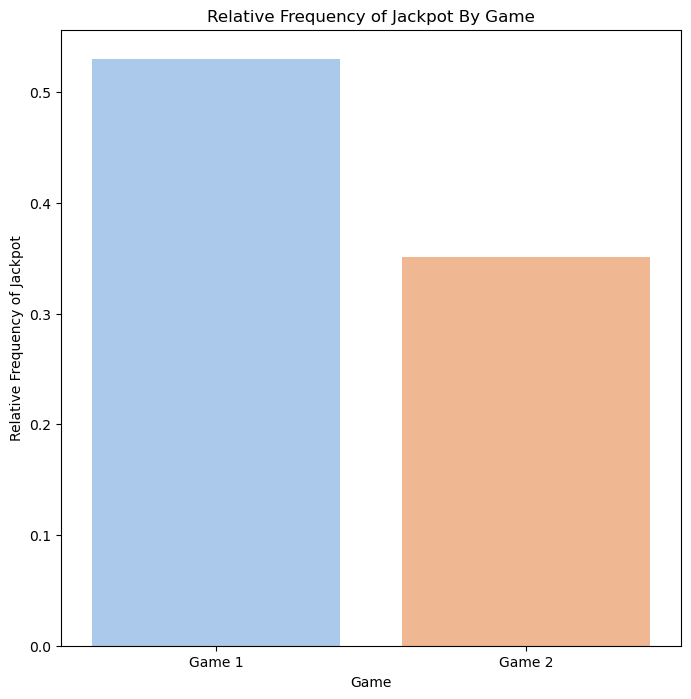

In [37]:
freqs = [analyzer1.jackpot()/1000, analyzer2.jackpot()/1000]
plt.figure(figsize=(8,8))
sns.barplot(x=['Game 1', 'Game 2'], y=freqs, palette='pastel')
plt.xlabel('Game')
plt.ylabel('Relative Frequency of Jackpot')
plt.title('Relative Frequency of Jackpot By Game')

## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [38]:
dice = [1,2,3,4,5,6]
d_unfair1 = Die(np.array(dice))
d_unfair2 = Die(np.array(dice))
d_fair = Die(np.array(dice))

Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [39]:
d_unfair1.change_weight(6, 5)

Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [40]:
d_unfair2.change_weight(1, 5)

Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [41]:
game_fair = Game([d_fair, d_fair, d_fair, d_fair, d_fair])
game_fair.play(10000)
game_fair.last_play()

,dice-0,dice-1,dice-2,dice-3,dice-4
roll,,,,,
0,4,3,3,2,1
1,6,5,1,3,3
2,1,1,1,2,4
3,3,4,1,3,4
4,3,2,6,2,3
...,...,...,...,...,...
9995,4,6,1,6,4
9996,2,6,3,5,1
9997,2,5,3,5,5


Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [42]:
game_unfair = Game([d_unfair1, d_unfair2, d_fair, d_fair, d_fair])
game_unfair.play(10000)
game_unfair.last_play()

,dice-0,dice-1,dice-2,dice-3,dice-4
roll,,,,,
0,6,1,5,6,4
1,1,5,4,4,6
2,3,5,6,4,3
3,3,5,1,5,6
4,6,4,2,1,3
...,...,...,...,...,...
9995,6,1,5,4,1
9996,6,4,3,6,2
9997,6,1,2,1,2


Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

In [43]:
analyzer_fair = Analyzer(game_fair)
analyzer_unfair = Analyzer(game_unfair)
print('Relative frequency of jackpots in fair game:', analyzer_fair.jackpot()/10000)
print('Relative frequency of jackpots in game 2:', analyzer_unfair.jackpot()/10000)

Relative frequency of jackpots in fair game: 0.0011
Relative frequency of jackpots in game 2: 0.0007


Text(0.5, 1.0, 'Relative Frequency of Jackpot By Game')

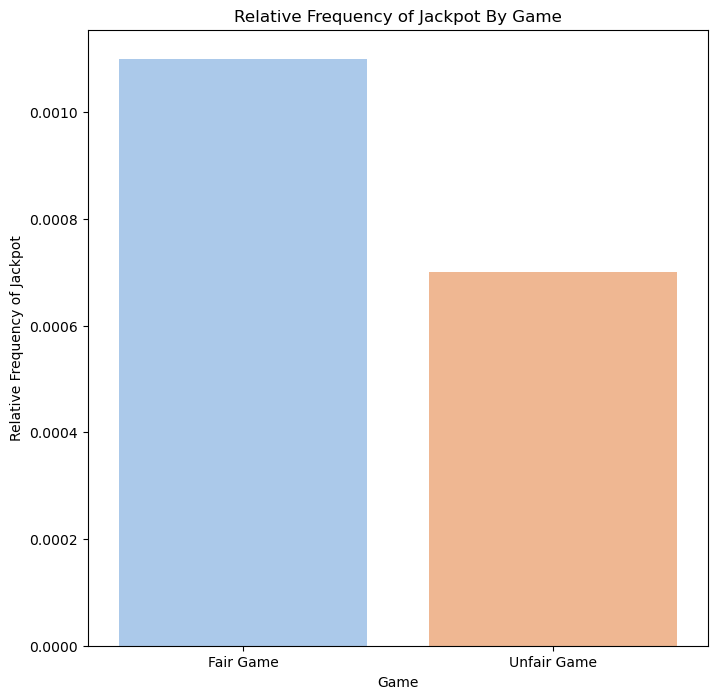

In [44]:
freqs = [analyzer_fair.jackpot()/10000, analyzer_unfair.jackpot()/10000]
plt.figure(figsize=(8,8))
sns.barplot(x=['Fair Game', 'Unfair Game'], y=freqs, palette='pastel')
plt.xlabel('Game')
plt.ylabel('Relative Frequency of Jackpot')
plt.title('Relative Frequency of Jackpot By Game')

## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [45]:
letters = pd.read_csv('text-files/english_letters.txt', sep=' ', header=None)
letters = letters.rename({0: 'letter', 1: 'weight'}, axis=1)
sides = letters['letter']
letters = letters.set_index('letter')
d = Die(np.array(sides))
for s in sides:
    d.change_weight(s, letters.loc[s]['weight'])
d.state()

,weights
sides,
E,529117365
T,390965105
A,374061888
O,326627740
I,320410057
N,313720540
S,294300210
R,277000841
H,216768975


Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [46]:
game = Game([d,d,d,d])
game.play(1000)
game.last_play()

,dice-0,dice-1,dice-2,dice-3
roll,,,,
0,R,T,L,O
1,M,I,E,N
2,F,N,T,A
3,M,G,I,D
4,E,M,S,A
...,...,...,...,...
995,N,R,L,T
996,L,I,E,E
997,O,J,P,W


Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [47]:
a = Analyzer(game)
permus = a.permutations().reset_index()
permus = permus[['dice-0', 'dice-1', 'dice-2', 'dice-3']]
permus['word'] = permus['dice-0']+permus['dice-1']+permus['dice-2']+permus['dice-3']
permus

,dice-0,dice-1,dice-2,dice-3,word
0,E,A,E,C,EAEC
1,I,E,R,O,IERO
2,E,O,S,T,EOST
3,N,O,N,E,NONE
4,T,E,T,A,TETA
...,...,...,...,...,...
987,H,A,O,A,HAOA
988,H,A,T,H,HATH
989,H,A,W,E,HAWE
990,H,C,T,T,HCTT


In [48]:
words = pd.read_csv('text-files/scrabble_words.txt', sep=' ', header=None)
words = words.rename({0:'word'}, axis=1)
words

,word
0,AA
1,AAH
2,AAHED
3,AAHING
4,AAHS
...,...
279491,ZYTHUMS
279492,ZYZZYVA
279493,ZYZZYVAS
279494,ZZZ


In [49]:
match = pd.merge(permus, words,
           on='word',
           how='outer',
           indicator='matched')
four_letter = match['matched'].value_counts()['both']
print(four_letter, 
      'words were in the permutation were also in the scrabble words list.')

45 words were in the permutation were also in the scrabble words list.


Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [50]:
game = Game([d,d,d,d,d])
game.play(1000)
game.last_play()
a = Analyzer(game)
permus = a.permutations().reset_index()
permus = permus[['dice-0', 'dice-1', 'dice-2', 'dice-3', 'dice-4']]
permus['word'] = permus['dice-0']+permus['dice-1']+permus['dice-2']+permus['dice-3']+permus['dice-4']
match = pd.merge(permus, words,
           on='word',
           how='outer',
           indicator='matched')
five_letter = match['matched'].value_counts()['both']
print(five_letter, 
      'words were in the permutation were also in the scrabble words list.')
if five_letter > four_letter:
    print('Higher percentage words generated by five letter permutations.')
else:
    print('Higher percentage words generated by four letter permutations.')

9 words were in the permutation were also in the scrabble words list.
Higher percentage words generated by four letter permutations.


# Submission

When finished completing the above tasks, save this file to your local repo (and within your project), and them push it to your GitHub repo.

Then convert this file to a PDF and submit it to GradeScope according to the assignment instructions in Canvas.